# Make a software package for generating train/test data

# Add resampling, and fix all the timescales

+ Utilities for combining models / directional forcing
+ Sample at same rate
+ Easily integrate ensembles of trajectories

In [41]:
%%bash 
pip install -I .

Processing /Users/williamgilpin/program_repos/dysts
  Created wheel for dysts: filename=dysts-0.0.0-py3-none-any.whl size=53779 sha256=f6b8c4e57d0053118df976a00dd270c2a33aa0b9818a61a52ece1c31f5dd2dd3
  Stored in directory: /private/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/pip-ephem-wheel-cache-ry354r35/wheels/11/5b/88/16c919af072e1e7c772aefa7da5a0b20f7490b27e409b1dcf5
Successfully built dysts


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [28]:
import sys

import matplotlib.pyplot as plt

import dysts
from dysts.flows import *
from dysts.maps import *
from dysts.base import *
from dysts.utils import *

from private.lyap import lyap_r, lyap_e, corr_dim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1.9809797221754644,
1.7610218652319016,
7.259385537100662,
1.8296071640677505


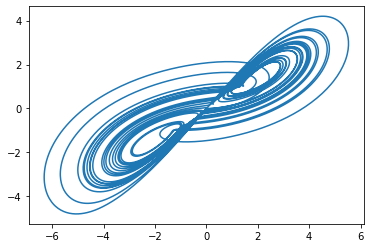

In [31]:
from dysts.base import DynSys, staticjit
from dysts.utils import integrate_dyn




model = Qi()
sol = model.make_trajectory(20000)
print(",\n".join([str(item) for item in sol[-1]]))

plt.plot(sol[:, 0], sol[:, 1])

In [32]:
np.random.random()

0.8297298082330516

(3, 2000)


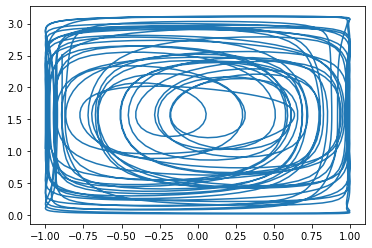

In [6]:
model = OscillatingFlow()
# model.period /= 100

sol = model.make_trajectory(2000, resample=True)

plt.plot(sol[:, 0], sol[:, 1])

(3, 5000)


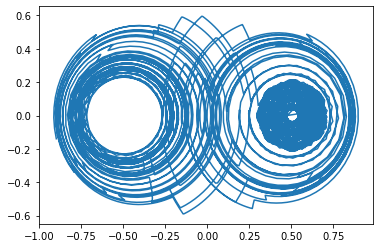

In [8]:
sol = BlinkingRotlet().make_trajectory(5000, resample=True)

plt.plot(sol[:, 0], sol[:, 1])

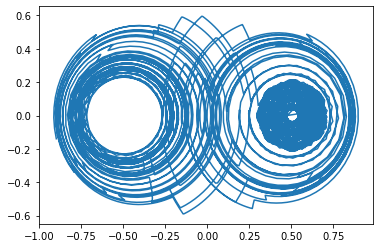

In [21]:



sol = BlinkingRotlet().make_trajectory(5000, resample=True)

plt.plot(*polar_to_cartesian(sol[:, 0], sol[:, 1]))


# plt.plot(*polar_to_cartesian(sol[:, 0], sol[:, 1]))

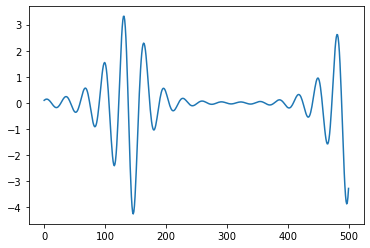

In [25]:
plt.plot(sol[:500, 0])

In [ ]:
# plt.plot(sol[0], sol[1], '.k', markersize=.1)
plt.plot(sol[:, 0], sol[:, 1], '-k', linewidth=0.2)
# plt.plot(sol[0][:50000], sol[1][:50000])

In [72]:
sol.shape

(5000, 10)

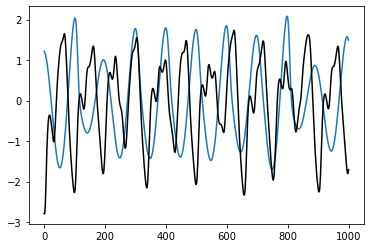

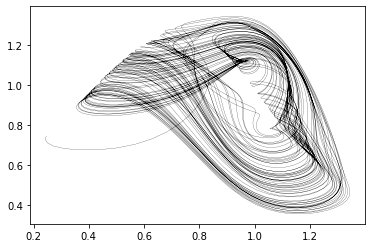

In [3]:
eq = MackeyGlass()
# eq.ic = np.vstack([eq.ic, eq.ic, eq.ic, eq.ic])

sol = eq.make_trajectory(5000, resample=True)
# eq.ic = np.vstack([eq.ic, eq.ic])

# plt.plot(sol[0], sol[1], '.k', markersize=.1)
plt.plot(sol[:, 0], sol[:, 1], 'k')
# plt.plot(sol[0][:50000], sol[1][:50000])

In [9]:
all_attractors = sorted(get_attractor_list())

for i, item in enumerate(all_attractors):
    eq = getattr(dysts.flows, item)()
    if len(eq.ic) < 3:
        print(eq.name)

IkedaDelay
MackeyGlass
PiecewiseCircuit
ScrollDelay
SprottDelay
VossDelay


## Improve stochastic integration

In [30]:
@sdepy.integrate
def my_process(t, x, theta=1., k=1., sigma=1.):
    return {'dt': k*(theta - x), 'dw': sigma}

coarse_timeline = np.linspace(0, 1, 100)
timeline = np.linspace(0., 1., 500)
x = my_process(x0=1, paths=10,
               steps=100)(coarse_timeline)
x.shape

(100, 10)

## Make Lorenz Ensemble for classification

In [ ]:
def make_ensemble(model, n_samples, frac_perturb_param=.1, 
                  n_classes=2, frac_transient=0.1, ic_range=None,
                  random_state=0):
    """
    Generate an ensemble of trajectories with random initial conditions, labelled by different
    sets of parameters.
    
    tpts : the timesteps over which to run the simulation
    params : iterable, the starting values for the parameters
    n_samples : int, the number of different initial conditons
    n_classes : int , the number of different parameters
    frac_perturb_param : float, the amount to perturb the parameters by
    frac_transient : float, the fraction of time for the time series to settle onto the attractor
    ic_range : a starting value for the initial conditions
    random_state : int, the seed for the random number generator
    """
    np.random.seed(random_state)
    
    ntpts = len(tpts0)
    dt = tpts0[1] - tpts0[0]
    t_range = tpts0[-1] - tpts0[0]
    tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
    num_per_class = int(n_samples/n_classes)

    all_params = list()
    all_samples = list()
    for i in range(n_classes):
    
        params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
        params_prime = params*params_perturb
        all_params.append(params_prime)
    
        eq = Lorenz(*params_prime)
        
        all_samples_per_class = list()
        for j in range(num_per_class):
            ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
            sol = integrate_dyn(eq, ic_prime, tpts)
            
            all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
        all_samples.append(all_samples_per_class)
    
    all_samples, all_params = np.array(all_samples), np.array(all_params)
    return all_samples, all_params
    
num_samples = 120

data, labels = generate_lorenz_ensemble(np.linspace(0, 500, 125000), 2*num_samples, (10, 28, 2.5), 
                                    n_classes=8, frac_perturb_param=.2, frac_transient=.2)


# Sprott family

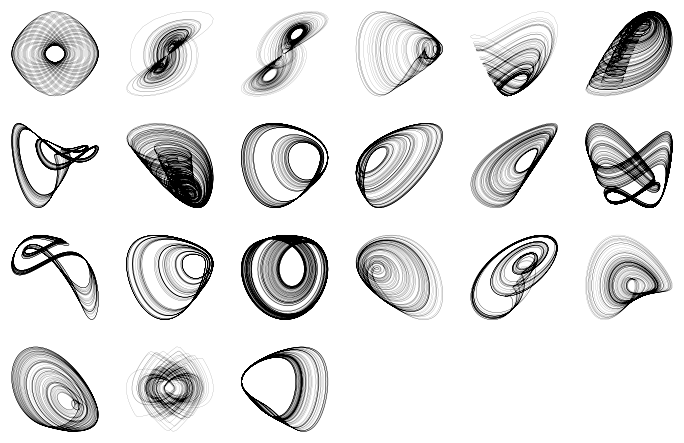

In [3]:
np.random.seed(0)
all_ensembles = list()
plt.figure(figsize=(12, 12))
for i, model in enumerate([SprottA(), SprottB(), SprottC(), SprottD(), SprottE(), SprottF(), SprottG(), 
              SprottH(), SprottI(), SprottJ(), SprottK(), SprottL(), SprottM(),
              SprottN(), SprottO(),SprottP(), SprottQ(), SprottR(), SprottS(), SprottMore(), SprottJerk()]):
    sol = model.make_trajectory(10000, resample=True)
    plt.subplot(6, 6, i+1)
    plt.plot(sol[:, 0], sol[:, 1], '-k', linewidth=0.1)
    plt.axis('off')

Aizawa   0 / 118
AnishchenkoAstakhov   1 / 118
Arneodo   2 / 118
ArnoldBeltramiChildress   3 / 118
ArnoldWeb   4 / 118
BeerRNN   5 / 118
BelousovZhabotinsky   6 / 118


/Users/williamgilpin/program_repos/dysts/dysts/flows.py:366: RuntimeWarning: invalid value encountered in sqrt
  rf = (self.ci - self.z0*z)*np.sqrt(x)


BickleyJet   7 / 118
Blasius   8 / 118
BlinkingRotlet   9 / 118
BlinkingVortex   10 / 118
Bouali   11 / 118
Bouali2   12 / 118
BurkeShaw   13 / 118
CaTwoPlus   14 / 118
CaTwoPlusQuasiperiodic   15 / 118
CellCycle   16 / 118
CellularNeuralNetwork   17 / 118
Chen   18 / 118
ChenLee   19 / 118
Chua   20 / 118
CircadianRhythm   21 / 118
CoevolvingPredatorPrey   22 / 118
Colpitts   23 / 118
Coullet   24 / 118
Dadras   25 / 118
DequanLi   26 / 118
DoubleGyre   27 / 118
DoublePendulum   28 / 118
Duffing   29 / 118
ExcitableCell   30 / 118
Finance   31 / 118
FluidTrampoline   32 / 118
ForcedBrusselator   33 / 118
ForcedFitzHughNagumo   34 / 118
ForcedVanDerPol   35 / 118
GenesioTesi   36 / 118
GuckenheimerHolmes   37 / 118
Hadley   38 / 118
Halvorsen   39 / 118
HastingsPowell   40 / 118
HenonHeiles   41 / 118
HindmarshRose   42 / 118
Hopfield   43 / 118
HyperRossler   44 / 118
IkedaDelay   45 / 118
IsothermalChemical   46 / 118
ItikBanksTumor   47 / 118
JerkCircuit   48 / 118
KawczynskiStrizha

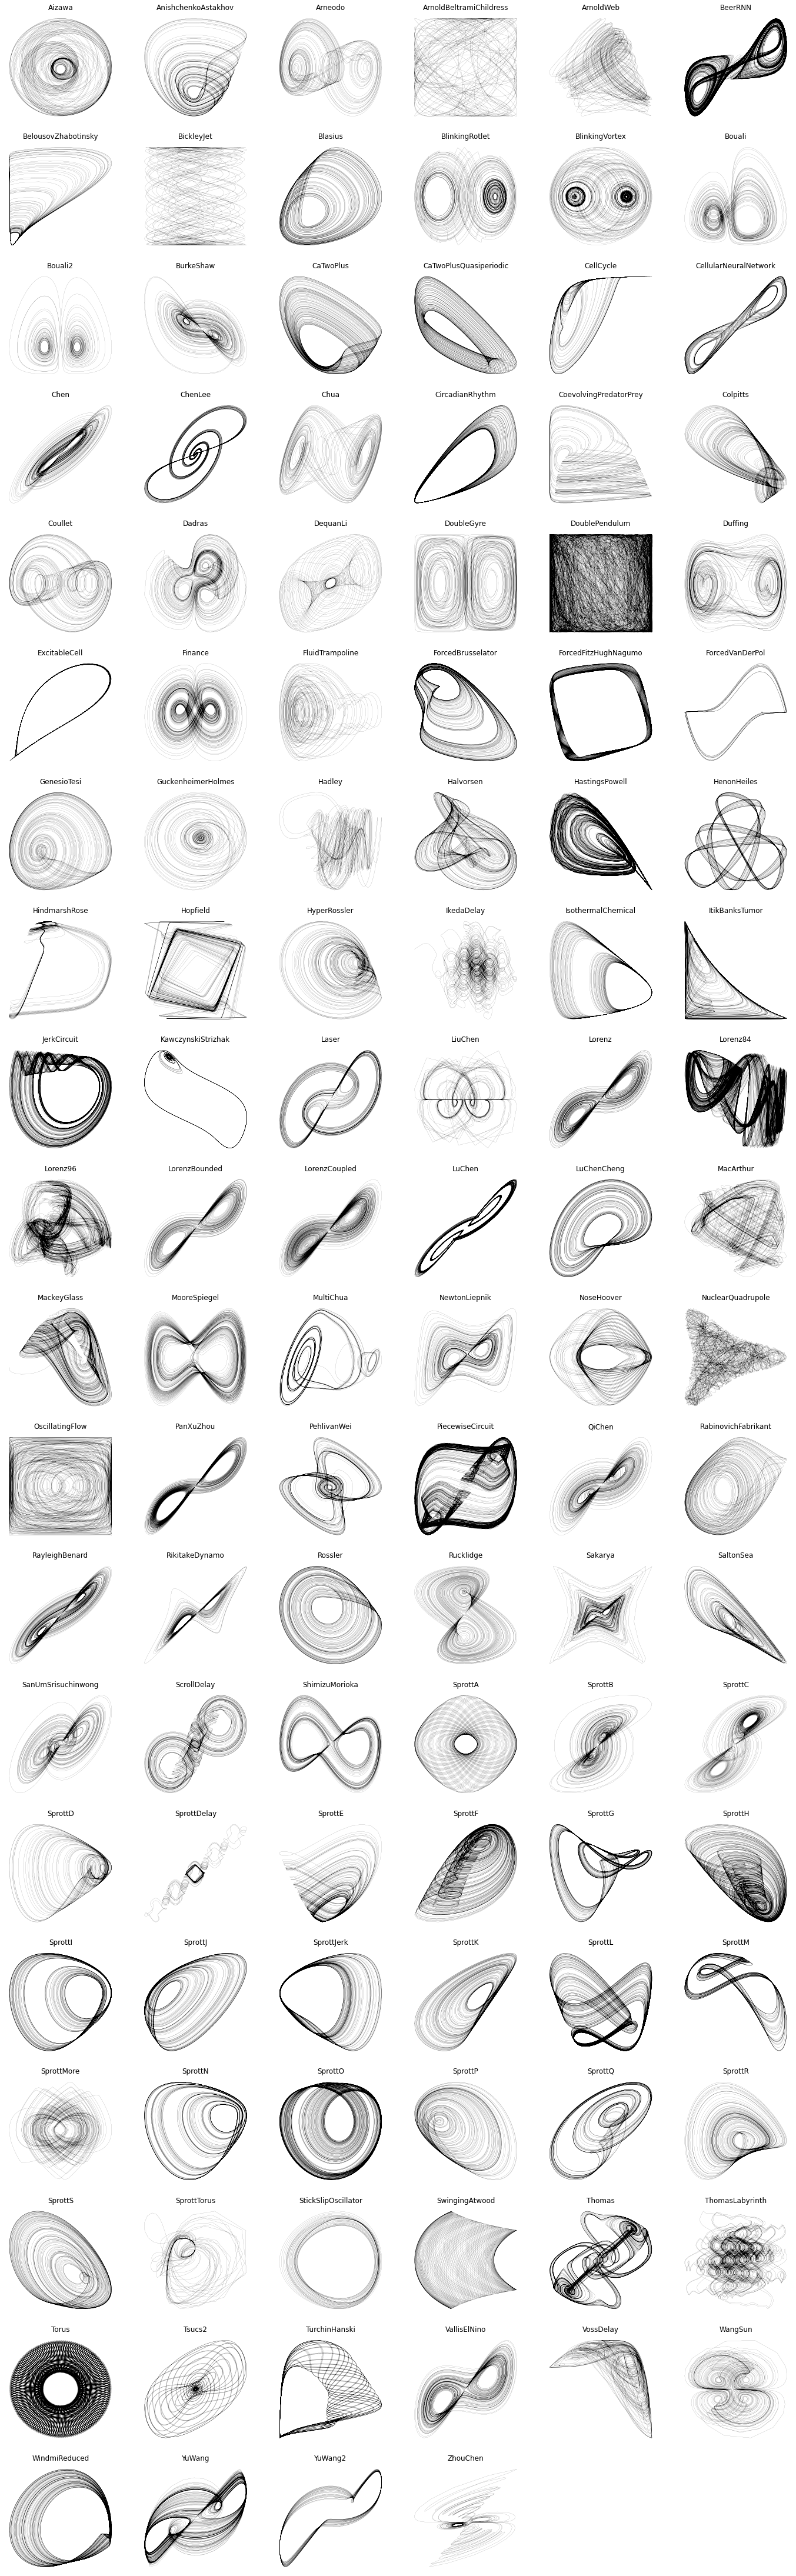

In [4]:

## Plot all attractors

all_attractors = sorted(get_attractor_list())

num_cols = 6
num_rows = int(np.ceil(len(all_attractors) / num_cols))
plt.figure(figsize=(num_cols*4, num_rows*4))
dim_counts = list()
for i, item in enumerate(all_attractors):
    if i % 1 == 0: print(item, " ", i, "/", len(all_attractors))
    eq = getattr(dysts.flows, item)()
    sol = eq.make_trajectory(10000, method="Radau", resample=True)
    dim_counts.append(len(eq.ic))
    
#     # Map unbounded indices to compact interval
#     if "unbounded_indices" in list(eq._load_data().keys()):
#         for ind in eq._load_data()["unbounded_indices"]:
#             sol[ind] = np.sin(sol[ind]) 
    
    plt.subplot(num_rows, num_cols, i+1)
#     plt.plot(sol[0], sol[1], '.k', markersize=.1)
    plt.plot(sol[:, 0], sol[:, 1], 'k', linewidth=0.1)
    plt.gca().title.set_text(item)
    plt.gca().axis('off')
    
print(f"{len(all_attractors)} attractors plotted.")

### Find timescales and dt and write to databse

+ Numerical integration timestep is determined by the highest significant frequency in the power spectrum
+ Initial conditions are chosen to lie on the attractor, but as close to one other as possible (align phases)
+ Certain cases: BickleyJet, StickSlipOscillator fail and require manual fine-tuning of dt

In [88]:
import json

import dysts
from dysts.utils import standardize_ts, find_characteristic_timescale, freq_from_autocorr, freq_from_fft, resample_timepoints, integrate_dyn, signif


with open("dysts/data/chaotic_attractors.json", "r") as file:
    data = json.load(file)
print(len(data.keys()))



# We will make a local copy of the internal database
path_output = "./chaotic_attractors.json"


all_freqs = list()
all_sols = list()

transient_fraction = .25
total_length = 40000*10

for item in list(data.keys()):
# for item in ["FluidTrampoline"]:
    
    eq = getattr(dysts, item)()
    
    try:
        pts_per_period = 1000
        base_freq = 1 / pts_per_period
        sol0 = eq.make_trajectory(total_length, method="Radau")
        eq.ic = list(sol0[:, -1])
        sol = standardize_ts(sol0.T).T[:, int(transient_fraction * total_length):]

        for i in range(5):
            # freq = freq_from_autocorr(sol[0])
            # freq = freq_from_fft(sol[0])
            # freq = 1/find_characteristic_timescale(sol[0])
            freq = np.max(find_significant_frequencies(sol[0]))
            period = base_freq / freq
            eq.dt = eq.dt * period # larger period needs larger timestep
            sol0 = eq.make_trajectory(total_length, method="Radau")
            eq.ic = list(sol0[:, -1])
            sol = standardize_ts(sol0.T).T[:, int(transient_fraction * total_length):]
            print(freq, end = " ")
        print("\n")

        all_sols.append(sol)

        freq2 = freq_from_fft(sol[0])
        all_freqs.append((freq, freq2))

        data[item]["initial_conditions"] = [signif(item, 8) for item in eq.ic]
        data[item]["dt"] = signif(eq.dt, 4)
    
    except Exception as e:
        print(e)
        pass

# Save an updated copy of the database
with open(path_output, 'w') as f:
    json.dump(data, f, indent=4)

95
0.0011966666666666666 0.0010033333333333333 0.001 0.001 0.00083 



## Find and write period of each attractor
+ Expressed in units of dt

In [18]:
# We will make a local copy of the internal database
path_output = "./chaotic_attractors2.json"


total_length = 40000*100

total_length = 500000

with open("dysts/data/chaotic_attractors.json", "r") as file:
    data = json.load(file)
print(len(data.keys()))

for i, item in enumerate(list(data.keys())):
    
    eq = getattr(dysts, item)()
    sol = eq.make_trajectory(total_length, method="Radau")
    
    all_freqs = list()
    for comp in sol:
        try:
            freqs, amps = find_significant_frequencies(comp, return_amplitudes=True, significance_threshold=0.95)
            max_freq = freqs[np.argmax(np.abs(amps))]
        except:
            ## ignores time-like coordinates
            continue
        all_freqs.append(max_freq)
        print(".", end='')
    period = eq.dt * (1 / np.median(all_freqs))
    
#     freqs, amps = find_significant_frequencies(sol[0], return_amplitudes=True, significance_threshold=0.95)
#     max_freq = freqs[np.argmax(np.abs(amps))]
#     period = (1/max_freq) * eq.dt
    
    #period = np.median([1/freq_from_fft(item) * eq.dt for item in sol])
    
    data[item]["period"] = signif(period, 5)
    print(item, " time period", period," index period", period/eq.dt, " ", (1/eq.dt)/period)
    
with open(path_output, 'w') as f:
    json.dump(data, f, indent=4)

106
...Lorenz  time period 1.5008333333333332  index period 8333.333333333334   3699.5919041830366
...LorenzBounded  time period 1.3715789473684208  index period 5263.157894736842   2797.7234188297984
......LorenzCoupled  time period 1.620720720720721  index period 9009.00900900901   3429.7356847930764
...Lorenz84  time period 6.258620689655172  index period 17241.379310344826   440.16422679082336
....Lorenz96  time period 2.1969230769230768  index period 15384.615384615383   3187.549529615768
...Thomas  time period 4.968965517241379  index period 17241.379310344826   698.2967819113202
...ThomasLabyrinth  time period 6.05  index period 17241.379310344826   471.0437623207384
....HenonHeiles  time period 6.37  index period 2500.0   61.61140944724708
...Chua  time period 11.387931034482756  index period 17241.379310344826   132.94816568779763
...MultiChua  time period 2.258630952380952  index period 2976.1904761904757   583.4050334067967


/Users/williamgilpin/program_repos/thom/thom/thom.py:264: RuntimeWarning: overflow encountered in exp
  zdot = -z - x  - self.eps*(np.exp(y/self.y0) - 1)


...JerkCircuit  time period 9.727272727272728  index period 6493.506493506495   68.62732865003805
...Colpitts  time period 4.267592592592592  index period 9259.25925925926   508.40561598024306
..Duffing  time period 7.449579831932774  index period 4201.680672268908   75.71108776155715
...Torus  time period 6.36  index period 16666.666666666668   412.0353888954814
...Halvorsen  time period 1.488888888888889  index period 6944.444444444444   3132.657607484963
...MooreSpiegel  time period 1.288709677419355  index period 8064.5161290322585   4855.8821179791385
...Bouali2  time period 2.677922077922078  index period 6493.506493506493   905.4894770363165
...Bouali  time period 3.041095890410959  index period 6849.315068493151   740.6054703352
...Arneodo  time period 3.1640624999999996  index period 2604.1666666666665   260.12294873748925
...Coullet  time period 5.766331658291457  index period 2512.5628140703516   75.56447899905544
...Rucklidge  time period 6.0721311475409845  index period 81

/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:307: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:337: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:359: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


..BickleyJet  time period 86956.52173913043  index period 869.5652173913044   1.1500000000000001e-07
...ArnoldBeltramiChildress  time period 161.97727272727272  index period 22727.272727272728   0.8662418446037338


/Users/williamgilpin/program_repos/thom/thom/thom.py:313: RuntimeWarning: invalid value encountered in sqrt
  rf = (self.ci - self.z0*z)*np.sqrt(x)


...BelousovZhabotinsky  time period 0.018257142857142857  index period 23809.52380952381   71430728.92813906
...IsothermalChemical  time period 0.7678448275862069  index period 8620.689655172413   14621.606254286195
..ForcedBrusselator  time period 20.410526315789472  index period 10526.315789473683   25.267832373731988
..ForcedVanDerPol  time period 2.3163398692810455  index period 6535.9477124183   1218.1590734220304
..StickSlipOscillator  time period 1.6129032258064515  index period 16129.032258064515   6200.0
..ForcedFitzHughNagumo  time period 35.80357142857143  index period 17857.14285714286   13.930261627726196
...HindmarshRose  time period 1.7519565217391304  index period 21739.130434782608   7082.645745721839
......CellCycle  time period 204.70873786407765  index period 4854.368932038835   0.11584039195889985
....CircadianRhythm  time period 27.0  index period 15625.0   21.43347050754458
...CaTwoPlus  time period 1.3429824561403507  index period 8771.929824561403   4863.562149

In [ ]:
# Find the number of integration timepoints per period

import dysts

transient_fraction = 0.1
total_length = 100000
points_per_period = 1000

for item in list(data.keys())[:10]:
    eq = getattr(dysts, item)()
    sol = eq.make_trajectory(total_length)
    
    
    freq_ceiling = np.max(find_significant_frequencies(sol[0]))
    freq_dominant = freq_from_fft(sol[0])
    
    timepoints_per_cycle = int(freq_ceiling/freq_dominant)
    print(timepoints_per_cycle)
    
    sol = eq.make_trajectory(timepoints_per_cycle*2000)
#     sol = eq.make_trajectory(50000)
    
    plt.plot(np.linspace(0, 1, len(sol[0])), sol[0])
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    

## Plot attractors with matching dominant timescales

+ This does not look great, because the sub-leading timescales are clearly more important for some attractors

54226
82329
8698
103244
2807
10818
5741
1251
9800
103575


/Users/williamgilpin/program_repos/thom/thom/thom.py:264: RuntimeWarning: overflow encountered in exp
  zdot = -z - x  - self.eps*(np.exp(y/self.y0) - 1)


432
86205
1062
102916
26910
819
22441
13451
103295
2677


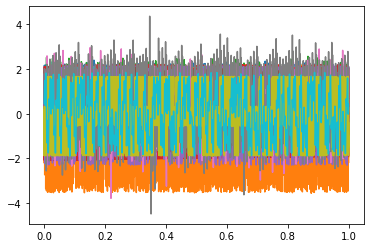

In [3]:
# Find the number of integration timepoints per period

import dysts

transient_fraction = 0.1
total_length = 100000
points_per_period = 1000

all_attractors = get_attractor_list()

for item in all_attractors[:20]:
    eq = getattr(dysts, item)()
    sol = eq.make_trajectory(total_length, method="Radau", resample=False)
    
    
    freq_ceiling = np.max(find_significant_frequencies(sol[0]))
    freq_dominant = freq_from_fft(sol[0])
    
    timepoints_per_cycle = int(freq_ceiling/freq_dominant)
    print(timepoints_per_cycle)
    
    sol = eq.make_trajectory(timepoints_per_cycle*200)
#     sol = eq.make_trajectory(50000)
    
    samp = sol[0]
    samp = (samp - np.mean(samp)) / np.std(samp)
    plt.plot(np.linspace(0, 1, len(sol[0])), samp)
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    

YuWang
YuWang2
ZhouChen


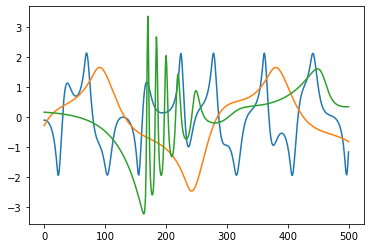

In [49]:
# Find the number of integration timepoints per period

import dysts

transient_fraction = 0.1
total_length = 500

all_attractors = get_attractor_list()

for item in all_attractors[110:]:
    print(item)
    eq = getattr(dysts, item)()
    sol = eq.make_trajectory(total_length, method="Radau", resample=True)
    
    
#     freq_ceiling = np.max(find_significant_frequencies(sol[0]))
#     freq_dominant = freq_from_fft(sol[0])
    
#     timepoints_per_cycle = int(freq_ceiling/freq_dominant)
#     print(timepoints_per_cycle)
    
#     sol = eq.make_trajectory(total_length)
#     sol = eq.make_trajectory(50000)
    
    samp = sol[0]
    samp = (samp - np.mean(samp)) / np.std(samp)
    plt.plot(samp)
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    
# plt.gca().legend()

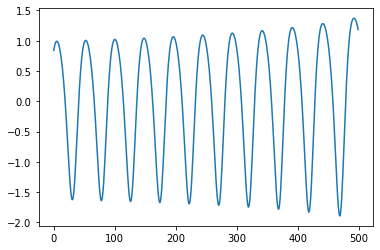

In [43]:
all_attractors = get_attractor_list()

eq = getattr(dysts, all_attractors[50])()

eq = getattr(dysts, "PanXuZhou")()
# eq.period *= 0.15
# eq = getattr(dysts, "Lorenz")()
sol = eq.make_trajectory(total_length, method="Radau", resample=True)

samp = sol[0]
samp = (samp - np.mean(samp)) / np.std(samp)
plt.plot(samp)

In [27]:

# insert a control function that takes the current values of all vars and adds forcing

# various functions for sampling from each system, and removing transients

# function that goes to numba

# function that couples attractors together (can use slaving to force chaos)

In [ ]:
#https://stackoverflow.com/questions/1796180/how-can-i-get-a-list-of-all-classes-within-current-module-in-python

In [ ]:
## Some day have an API working

import inspect


def generate_data(model, n_samples, params, frac_perturb_param=.1, 
                             n_classes=2, frac_transient=0.1, 
                             ic_range=None,
                            random_state=0):
    """
    Generate an ensemble of trajectories with random initial conditions, labelled by different
    sets of parameters.

    model : an instantiation of a dynamical system
    tpts : the timesteps over which to run the simulation
    params : iterable, the starting values for the parameters
    n_samples : int, the number of different initial conditons
    n_classes : int , the number of different parameters
    frac_perturb_param : float, the amount to perturb the parameters by
    frac_transient : float, the fraction of time for the time series to settle onto the attractor
    ic_range : a starting value for the initial conditions
    random_state : int, the seed for the random number generator
    """

    num_per_class = int(n_samples/n_classes)

    params = inspect.getfullargspec(model.__init__).defaults # get default values of params
    
    params = model.get_params()

    param_fractional_perturb = frac_perturb*2*(np.random(len(model.default_params)) - 0.5)
    params = model.default_params*param_fractional_perturb

    mod = model(*params)
    
    
    
    
    np.random.seed(random_state)
    
    ntpts = len(tpts0)
    dt = tpts0[1] - tpts0[0]
    t_range = tpts0[-1] - tpts0[0]
    tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
    all_params = list()
    all_samples = list()
    for i in range(n_classes):
    
        params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
        params_prime = params*params_perturb
        all_params.append(params_prime)
    
        eq = Lorenz(*params_prime)
        
        all_samples_per_class = list()
        for j in range(num_per_class):
            ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
            sol = integrate_dyn(eq, ic_prime, tpts)
            
            all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
        all_samples.append(all_samples_per_class)
    
    all_samples, all_params = np.array(all_samples), np.array(all_params)
    return all_samples, all_params